In [1]:
import cv2
import torch
from Encoders import TimeToFirstSpikeEncoding, GaussianEncoding, PoissonEncoding
from matplotlib import pyplot as plt
from pymonntorch import *
import numpy as np
from timeRes import TimeResolution
from current import *
from lif import LIF, InputPattern
from synapse import *
from connections import Connections
from learning import STDP, KWTA
from homeostatis import *

In [27]:
# read an image and convert it to torch tensor
def image_to_vec(address, size=(10, 10)):
    img = cv2.imread(address)
    img = cv2.resize(img, (size[0], size[1]))
    img = torch.from_numpy(img)
    img = img.sum(2)//3

    return img


def show_image(img):
    plt.imshow(img, cmap='gray')  
    plt.show()


def raster_plot(spikes, fsize=(5,5)):
    
    plt.figure(figsize=fsize)
    plt.xlim(0, len(spikes))
    s_spikes = torch.nonzero(spikes)
    plt.scatter(s_spikes[:,0], s_spikes[:,1], s=2, c='darkviolet')
    plt.yticks(np.arange(0, 9))
        
    plt.xlabel("Time")
    plt.ylabel("Neurons")
    plt.show()

def fill_pattern(pattern, n_free, is_right=True):
    pattern = pattern.transpose(-2, 1)
    shape = pattern.shape
    new_pattern = torch.zeros(shape[0]+n_free, shape[1])
    if is_right:
        for i in range(pattern.shape[0]):
            for j in range(pattern.shape[1]):
                new_pattern[i][j] = pattern[i][j] 
    else:
        for i in range(pattern.shape[0]):
            for j in range(pattern.shape[1]):
                new_pattern[i+n_free][j] = pattern[i][j]

    return new_pattern


def noisy_pattern(pattern1, n=300):
    indexesi = [random.randint(0, 99) for _ in range(n)]
    indexesj = [random.randint(0, 8) for _ in range(n)]

    k = 0
    for i in range(n):
        if pattern1[indexesi[k]][indexesj[k]]:
            pattern1[indexesi[k]][indexesj[k]] = False
        else:
            pattern1[indexesi[k]][indexesj[k]] = True
        k += 1

    return pattern1
            

def neg_pat(pattern):
    new_pat = torch.zeros(pattern.shape[0], pattern.shape[1])
    for i in range(pattern.shape[0]):
        for j in range(pattern.shape[1]):
            if pattern[i][j]:
                new_pat[i][j] = 0
            else:
                new_pat[i][j] = 1

    return new_pat

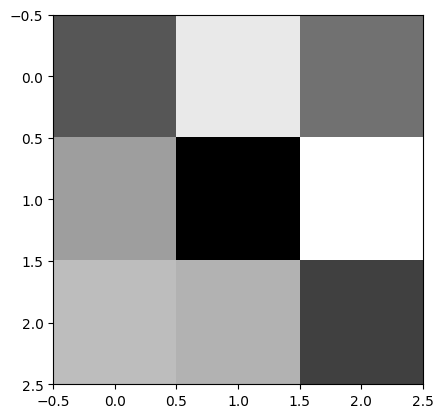

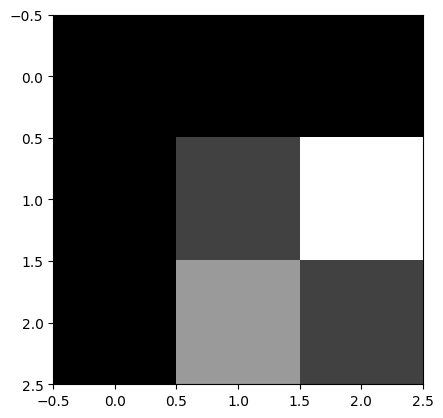

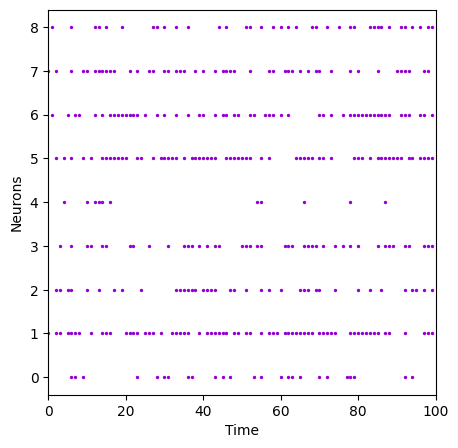

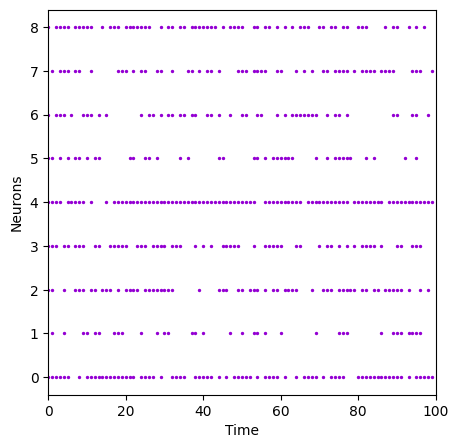

In [28]:
img1 = image_to_vec('images/barb.tif', (3, 3))
show_image(img1)
img2 = image_to_vec('images/circles.tif', (3, 3))
show_image(img2)
# img3 = image_to_vec('images/lena1.tif', (3, 3))
# show_image(img3)
# img4 = image_to_vec('images/library.tif', (50, 50))
# show_image(img4)

pe1 = PoissonEncoding(img1, 100, 100)
pe2 = PoissonEncoding(img2, 100, 100)
# pe3 = PoissonEncoding(img3, 100, 100)
# pe4 = PoissonEncoding(img4, 100, 100)

pe_spikes1 = pe1.encode()
pe_spikes2 = pe2.encode()
# pe_spikes3 = pe3.encode()
# pe_spikes4 = pe4.encode()

# raster_plot(pe_spikes1)
# raster_plot(pe_spikes2)
# raster_plot(pe_spikes3)
# raster_plot(pe_spikes4)

pattern1 = fill_pattern(pe_spikes1, 0)
pattern2 = neg_pat(pe_spikes1)
# pattern2 = pattern2.transpose(-2, 1)
# pattern1 = fill_pattern(pattern1, 100)
pattern2 = fill_pattern(pattern2, 0, False)
pattern1 = pattern1.transpose(-2, 1)
pattern2 = pattern2.transpose(-2, 1)
raster_plot(pattern1)
raster_plot(pattern2)
# p1 = pattern1.copy()
# p2 = pattern2.copy()
# pattern1 = noisy_pattern(pattern1)
# pattern2 = noisy_pattern(pattern2)
# raster_plot(pattern1)
# raster_plot(pattern2)


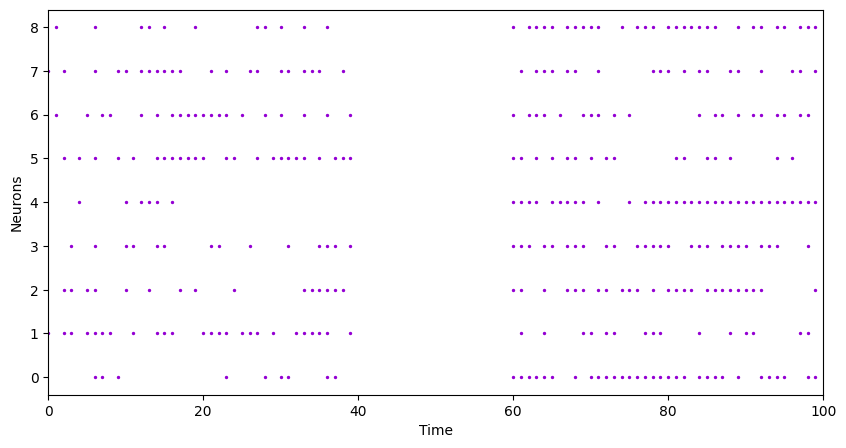

In [29]:
patt = torch.zeros(100, 9)
for i in range(100):
    for j in range(pattern2.shape[1]):
        if i < 40:
            patt[i][j] = pattern1[i][j]
        elif i >= 40 and i < 60:
            patt[i][j] = 0
        else:
            patt[i][j] = pattern2[i-60][j]
raster_plot(patt, fsize=(10, 5))


In [5]:

net = Network(behavior={1: TimeResolution()}, dtype=torch.float64)
input_ng = NeuronGroup(
    9,
    net=net,
    behavior={
        7: InputPattern(pattern=pattern1, pattern2=pattern2, cpt=40, sleep=20, tau_t=10, num_rep=100),
    },
    tag="inp_NG1",
)


output_ng = NeuronGroup(
    2,
    net=net,
    behavior={
        2: ConstantCurrent(value=0),
        5: InpSyn(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-55,
            R=20,
            N=2,
        ),
        9: Recorder(variables=["v", "I"], tag="inh_ng1_rec, inh_ng1_recorder"),
        10: EventRecorder("spike", tag="inh_ng1_evrec"),
    },
    tag="out_NG2",
)

connect_inp_out = SynapseGroup(net=net,
                src=input_ng, 
                dst=output_ng, 
                behavior={
                    3: SynFun(),
                    4: STDP(lr=[0.3,2],wd=1000, wmin=0, wmax=1),
                    5: Connections(type="full"),    
                    11: Recorder(variables=["W"], tag="layers weights"),  
                })
net.initialize()
net.simulate_iterations(100)

Network['Network_1', 'Network'](Neurons: tensor(11)|2 groups, Synapses: tensor(18)|1 groups){1:TimeResolution()}
NeuronGroup['inp_NG1', 'NeuronGroup', 'ng'](9){7:InputPattern(pattern=tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.]]),pattern2=tensor([[0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.]]),cpt=40,sleep=20,tau_t=10,num_rep=100,)}
NeuronGroup['out_NG2', 'NeuronGroup', 'ng'](2){2:ConstantCurrent(value=0,)5:InpSyn()7:LIF(tau=10,u_rest=-65,u_reset=-73.42,threshold=-55,R=20,N=2,)9:Recorder(variables=['v', 'I'],gap_width=0,max_length=None,auto_annotate=True,tag=inh_ng1_rec, inh_ng1_recorder,

IndexError: The shape of the mask [14] at index 0 does not match the shape of the indexed tensor [9, 2] at index 0

100


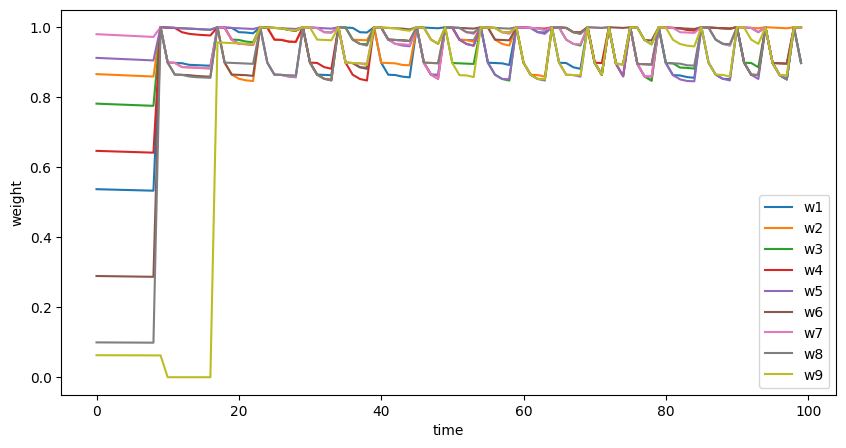

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


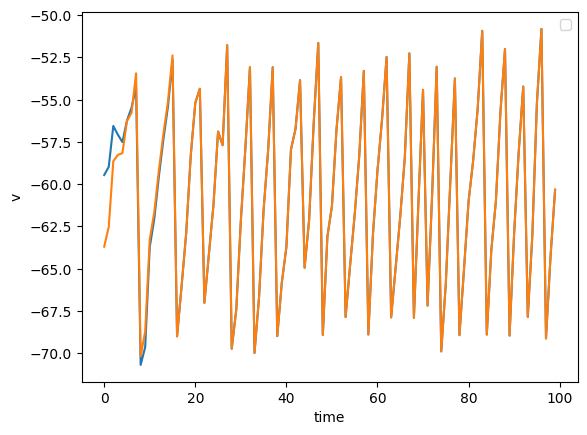

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


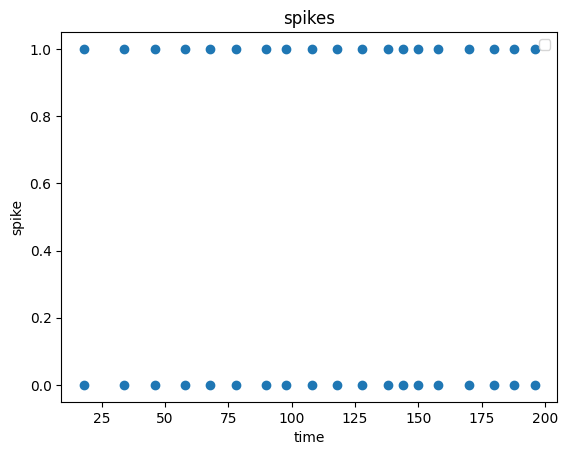

In [ ]:
vars1 = []
vars2 = []
time = [i for i in range(100)]
for i in range(9):
    x = []
    y = []
    for j in range(100):
        x.append(net["W", 0][j][i][0])
        y.append(net["W", 0][j][i][1])
    vars1.append(x)
    vars2.append(y)

print(len(vars1[0]))
plt.figure(figsize=(10, 5))
for i in range(9):
    
    # plt.plot(time, vars1[i], label=f"w{i+1}")
    plt.plot(time, vars2[i], label=f"w{i+1}")

plt.xlabel("time")
plt.ylabel("weight")
plt.legend()
plt.show()
plt.plot(net["v", 0])
# plt.plot(net["v", 1])
plt.xlabel("time")
plt.ylabel("v")
plt.legend()
plt.show()
plt.scatter(net["spike", 0][:,0], net["spike", 0][:,1])
# plt.scatter(net["spike", 0][:,1], net["spike", 0][:,1])
plt.ylabel("spike")
plt.xlabel("time")
plt.title("spikes")
plt.legend()
plt.show()

In [70]:

net = Network(behavior={1: TimeResolution()}, dtype=torch.float64)
input_ng = NeuronGroup(
    9,
    net=net,
    behavior={
        7: InputPattern(pattern=pattern1, pattern2=pattern2, cpt=40, sleep=20, tau_t=10),
        8: KWTA(k=2),
        10: EventRecorder("spike", tag="inh_ng1_evrec"),
    },
    tag="inp_NG1",
)


output_ng = NeuronGroup(
    2,
    net=net,
    behavior={
        2: ConstantCurrent(value=0),
        5: InpSyn(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-55,
            R=20,
            N=2,
        ),
        # 8: KWTA(k=2),
        9: Recorder(variables=["v", "I"], tag="inh_ng1_rec, inh_ng1_recorder"),
        10: EventRecorder("spike", tag="inh_ng1_evrec"),
    },
    tag="out_NG2",
)

connect_inp_out = SynapseGroup(net=net,
                src=input_ng, 
                dst=output_ng, 
                behavior={
                    3: SynFun(),
                    4: STDP(lr=[1,8],wd=2000, wmin=0, wmax=1),
                    5: Connections(type="full"),    
                    11: Recorder(variables=["W"], tag="layers weights"),  
                })

net.initialize()
net.simulate_iterations(100)

Network['Network_1', 'Network'](Neurons: tensor(11)|2 groups, Synapses: tensor(18)|1 groups){1:TimeResolution()}
NeuronGroup['inp_NG1', 'NeuronGroup', 'ng'](9){7:InputPattern(pattern=tensor([[0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 1., 0., 1., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 1., 0., 0.],
        [1., 1., 1., 1., 0., 1., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 1., 1., 1., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 1., 1.],
        [0., 0., 1., 0., 1., 0., 0., 1., 1.],
        [0., 1., 0., 1., 1., 1., 1., 1., 0.],
        [0., 1., 0., 1., 0., 1., 0., 1., 1.],
        [0., 1., 0., 0., 1., 1., 1., 1., 0.],
        [0., 0., 1., 0., 0., 1., 1.

692.8708553314209

100


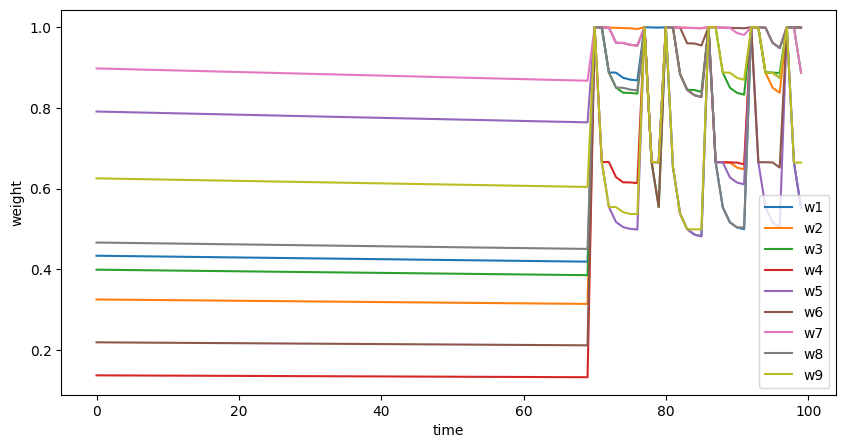

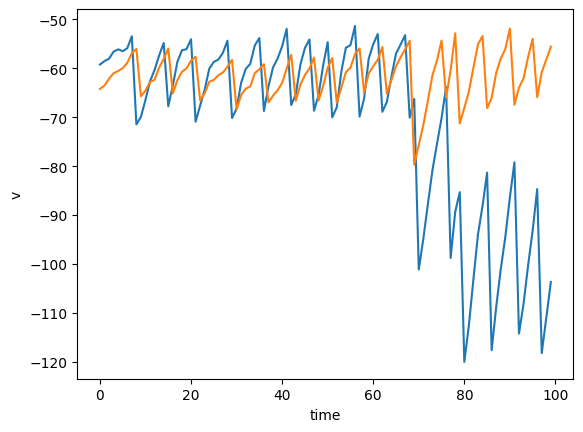

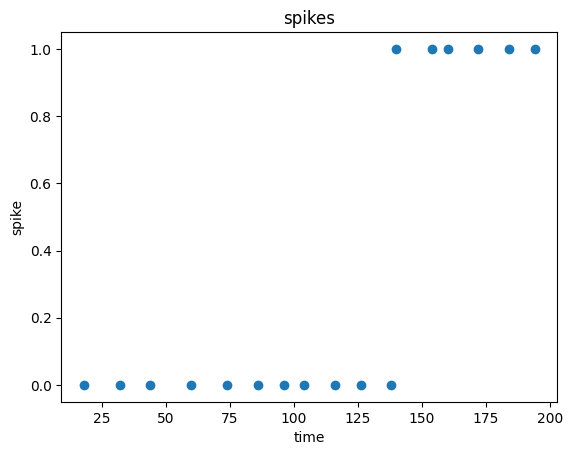

In [73]:
vars1 = []
vars2 = []
time = [i for i in range(100)]
for i in range(9):
    x = []
    y = []
    for j in range(100):
        x.append(net["W", 0][j][i][0])
        y.append(net["W", 0][j][i][1])
    vars1.append(x)
    vars2.append(y)

print(len(vars1[0]))
plt.figure(figsize=(10, 5))
for i in range(9):
    
    # plt.plot(time, vars1[i], label=f"w{i+1}")
    plt.plot(time, vars2[i], label=f"w{i+1}")

plt.legend()
plt.xlabel("time")
plt.ylabel("weight")
plt.show()
plt.plot(net["v", 0])
plt.xlabel("time")
plt.ylabel("v")
# plt.plot(net["v", 1])
plt.show()
# plt.scatter(net["spike", 0][:,0], net["spike", 0][:,1], s=1)
plt.scatter(net["spike", 1][:,0], net["spike", 1][:,1])
# plt.scatter(net["spike", 0][:,1], net["spike", 0][:,1])
plt.ylabel("spike")
plt.xlabel("time")
plt.title("spikes")
plt.show()

In [ ]:

net = Network(behavior={1: TimeResolution()}, dtype=torch.float64)
input_ng = NeuronGroup(
    8,
    net=net,
    behavior={
        7: InputPattern(pattern=pattern1, pattern2=pattern2, cpt=40, sleep=20, tau_t=10),
    },
    tag="inp_NG1",
)


output_ng = NeuronGroup(
    2,
    net=net,
    behavior={
        2: ConstantCurrent(value=0),
        5: InpSyn(),
        7: LIF(
            tau=10,
            u_rest=-65,
            u_reset=-73.42,
            threshold=-55,
            R=20,
            N=2,
        ),
        8: KWTA(k=2),
        9: ActivityBaseHomeostasis(activity_rate=2, window_size=10, updating_rate=0.2),
        10: Recorder(variables=["v", "I"], tag="inh_ng1_rec, inh_ng1_recorder"),
        11: EventRecorder("spike", tag="inh_ng1_evrec"),
    },
    tag="out_NG2",
)

connect_inp_out = SynapseGroup(net=net,
                src=input_ng, 
                dst=output_ng, 
                behavior={
                    3: SynFun(),
                    4: STDP(lr=[2,5],wd=1000000, wmin=0, wmax=2),
                    5: Connections(type="full"),    
                    12: Recorder(variables=["W"], tag="layers weights"),  
                })

net.initialize()
net.simulate_iterations(100)

Network['Network_1', 'Network'](Neurons: tensor(10)|2 groups, Synapses: tensor(16)|1 groups){1:TimeResolution()}
NeuronGroup['inp_NG1', 'NeuronGroup', 'ng'](8){7:InputPattern(pattern=tensor([[0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 0., 1.

525.6860256195068

100


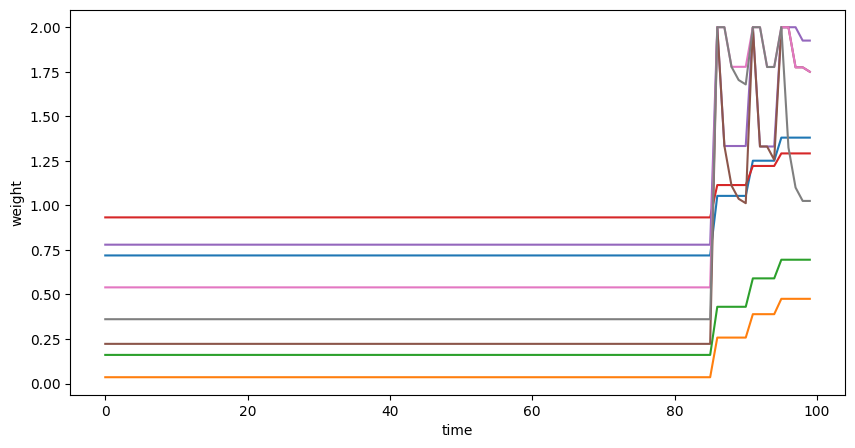

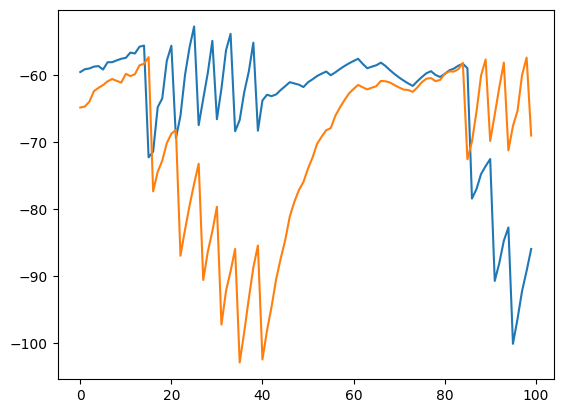

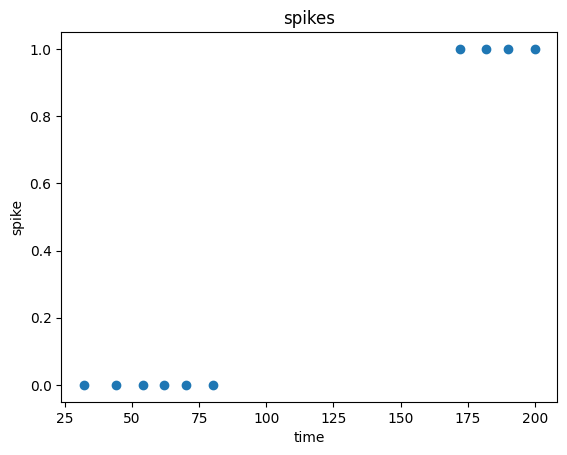

In [ ]:
vars1 = []
vars2 = []
time = [i for i in range(100)]
for i in range(8):
    x = []
    y = []
    for j in range(100):
        x.append(net["W", 0][j][i][0])
        y.append(net["W", 0][j][i][1])
    vars1.append(x)
    vars2.append(y)

print(len(vars1[0]))
plt.figure(figsize=(10, 5))
for i in range(8):
    
    # plt.plot(time, vars1[i])
    plt.plot(time, vars2[i])

plt.xlabel("time")
plt.ylabel("weight")
plt.show()
plt.plot(net["v", 0])
# plt.plot(net["v", 1])
plt.show()
plt.scatter(net["spike", 0][:,0], net["spike", 0][:,1])
# plt.scatter(net["spike", 0][:,1], net["spike", 0][:,1])
plt.ylabel("spike")
plt.xlabel("time")
plt.title("spikes")
plt.show()